In [9]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from particle_markov_chain_monte_carlo import Sequential_Monte_Carlo

non ci sono le phii
tempo esecuzione :  0.09768509864807129
marginal Y =  1.0880995455639051e+59
12


[99718.31933350406,
 99635.71282686872,
 99527.27987394451,
 96808.3090886044,
 98117.15832495813,
 92544.09122306286,
 88886.29521807222,
 85883.32644389261,
 74459.63751850341,
 68634.79747912016,
 55657.06741946789,
 57650.21937799157]

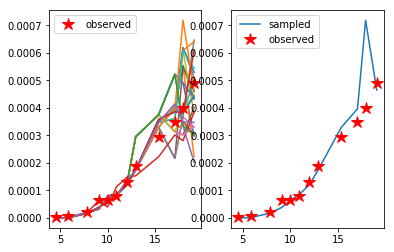

In [23]:
start = time()
SMC = Sequential_Monte_Carlo()#number_of_particles= 25)

# il parametro sigma non ha senso che sia più piccolo di 1e-5 
# o più grande di 1e-3

theta = [0.27, 5e-4, 0.04, 35e-4, 0.18, 1e-4]
#theta = [0.1598523555361324 , 0.0054268859793400086, 0.5, 35e-3, 0.2, 1e-3]
SMC.fit_SMC(4, theta)

print("tempo esecuzione : ", time()-start)

f, (ax1, ax2) = plt.subplots(1,2)
for i in range(SMC.np):
    ax1.plot(SMC.timei, SMC.X_tot[i, :])

ax1.plot(SMC.timei, SMC.yobsi, "r*", markersize=12, label = "observed")
ax1.legend()
print("marginal Y = ", SMC.marginal_y)

ax2.plot(SMC.timei, SMC.sampling_a_path().flatten(), label = "sampled")
ax2.plot(SMC.timei, SMC.yobsi, "r*", markersize=12, label = "observed")
ax2.legend()
print(len(SMC.timei))

SMC.marginal_particle

In [6]:
import numpy as np
from scipy.stats import norm, multivariate_normal

class dati:
    def __init__(self):
        data = np.genfromtxt('FreyerSutherland.dat')
        self.names = data[1:]
        data = data[1:]
        self.time = data[:,0]
        self.yobs = data[:,1]
        self.subj = data[:,2]

    def select_subj(self, num):
        self.timei = self.time[self.subj == num]
        self.yobsi = self.yobs[self.subj == num]

class Sequential_Monte_Carlo(dati):
    def __init__(self,  number_of_particles = 25, proposal = []):  #IDS, LDS, OD,
        #self.initial_distr_sampler = IDS     # this is the function used to sample the initial distribution
        #self.latent_transition_sampler = LDS   # this samples from transition distribution is used as proposal
        #self.observed_distr = OD   # the observed error is the function used to reweight the particles
        dati.__init__(self)
        self.np = number_of_particles
        if proposal:   # in caso ci siano proposals
            self.init_prop = proposal[0]
            self.transition_prop = proposal[1]
    
    def fit_SMC(self, soggetto , theta, phi=[]):
        self.soggetto = soggetto
        self.select_subj(self.soggetto)
        self.Y = self.yobsi
        self.marginal_particle = [0 for _ in range(len(self.Y))]
        self.marginal_y = 0
        self.theta = theta
        if len(phi)==0:
            print("non ci sono le phii")
            self.phi = theta[:2]
        else:
            self.phi = phi
        self.X_tot = np.zeros((self.np, len(self.Y)))
        self.first_step()  # inizializza x(0)
        self.second_step() # completa le x_i per i = 1,...,len(Y)
    
    def first_step(self):
        X_0 = [self.initial_distr_sampler() for _ in range(self.np)]
        self.X_tot[:,0] = np.array(X_0)
        w_n = [self.observed_distr(x_0, 0) for x_0 in X_0]
        s_w =sum(w_n)
        self.marginal_particle[0] = s_w   # /self.np  ho deciso di toglierlo poiche nel MH scompare
        W_n = np.array(w_n)/s_w
        self.W = W_n
    
    def second_step(self):
        indeces = np.arange(self.np)
        A_n_m = np.random.choice(indeces , size=self.np, p= self.W)
        X_n_m = self.X_tot[A_n_m.tolist(),0]
        self.X_tot[:,0] = X_n_m
        for t in range(1,len(self.Y)):
            X_n = [self.latent_transition_sampler(x_1,t) for x_1 in X_n_m]
            self.X_tot[:,t]= np.array(X_n)
            
            w_n = [self.observed_distr(x, t) for x in X_n]
            s_w =sum(w_n)
            
            self.marginal_particle[t] = s_w    #/ self.np  ho deciso di toglierlo poiche nel MH scompare
            #print(t, self.marginal[t], s_w)
            self.W = np.array(w_n)/s_w
            
            A_n_m = np.random.choice(indeces, size=self.np, p= self.W)
            
            self.X_tot[indeces.tolist(), 0:t] = self.X_tot[A_n_m.tolist(),0 : t]
            X_n_m = self.X_tot[:,t]
            
        self.marginal_y = np.prod(np.array(self.marginal_particle))
        
    def sampling_a_path(self):
        indeces = np.arange(self.np)
        part = np.random.choice(indeces, size=1, p= self.W)
        return self.X_tot[part, :]
    
    def initial_distr_sampler(self):
        return 1e-7
    
    def observed_distr(self, x_, t_ ):
        #foo = (x_ - self.Y[t_])/ self.theta[5]
        #p = 1/(np.sqrt(2*np.pi)* self.theta[5]) * np.exp(-(foo)**2/2)
        p = norm.pdf(x_,self.Y[t_], self.theta[5])
        if p ==0:
            p = 1e-100
        #print(t_, x_, p,p_s,  x_ - self.Y[t_], self.theta[5], foo)
        
        return p
    
    def latent_transition_sampler(self, x_t, time):
        ###   beta = theta[2]
        t_j = self.timei[time]; t_j_1 = self.timei[time-1]
        deltatime = (t_j - t_j_1)
        u_j = self.EulerStep(x_t, t_j_1, t_j, deltatime)
        s_j = self.theta[4] * u_j * np.sqrt(deltatime)
        x_t1 = u_j + s_j* np.random.normal()
        if x_t1 < 1e-30:
            x_t1 = 1e-30
        
        return x_t1
        
        
    def EulerStep(self, x_t, time0, time1, deltat):
        x_t1 = x_t
        time = time0
        deltat /= 100
        while time < time1:
            if (time1-time)>deltat:
                dt = deltat
            else:
                dt = time1-time
            x_t1 += self.ModelDrift(x_t1) * dt
            time += dt
        return x_t1
    
    def ModelDrift(self, X):
        return self.phi[0]* np.log(self.phi[1]/X)* X
        

non ci sono le phii


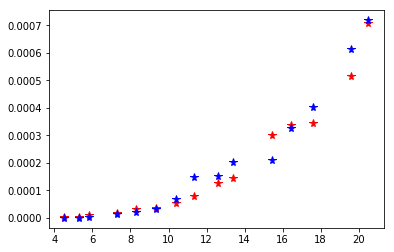

In [7]:
theta = [0.27, 5e-4, 0.04, 35e-4, 0.18, 1e-6]
SMC = Sequential_Monte_Carlo()
SMC.fit_SMC(1, theta)


plt.plot(SMC.timei, SMC.yobsi, "r*",markersize=8, label= "observed values")
plt.plot(SMC.timei, SMC.sampling_a_path().flatten(), "b*",markersize=8, label= "observed values")

In [8]:
SMC.marginal_particle , SMC.marginal_y

([365.1279534788216,
  41204.57454927014,
  8.573758961023967e-16,
  11824.925007540714,
  384796.7608201294,
  169068.21001375408,
  365371.8480092699,
  1192.6082738576283,
  0.0005949041211916197,
  67.06943135744541,
  1.1301518287516188e-11,
  5805.181648571163,
  381521.3181561878,
  5474.901173271133,
  1.8916556703062882e-18],
 0.04472474080476254)